# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import jdatetime
import re

# Load BIS nominal exchange rates Data
Source : https://data.bis.org/topics/XRU/data , Bulk Downloads, CSV Flat

In [2]:
df_bis = pd.read_csv("WS_XRU_csv_flat.csv")
keep_cols = ['FREQ:Frequency', 'OBS_VALUE:Observation Value', 'DECIMALS:Decimals',
              'REF_AREA:Reference area', 'CURRENCY:Currency', 'TIME_PERIOD:Time period or range', 
              'COLLECTION:Collection']
df_bis = df_bis[keep_cols]

df_bis = df_bis[(df_bis['FREQ:Frequency'] == 'M: Monthly')
         & (df_bis['DECIMALS:Decimals'] == '6: Six')
         & (df_bis['COLLECTION:Collection'] == 'A: Average of observations through period')]

keep_cols = ['OBS_VALUE:Observation Value', 'REF_AREA:Reference area',
              'CURRENCY:Currency', 'TIME_PERIOD:Time period or range']

df_bis = df_bis[keep_cols]

# Rename columns for convenience
df_bis = df_bis.rename(columns={
    'OBS_VALUE:Observation Value': 'Value',
    'REF_AREA:Reference area': 'Country',
    'CURRENCY:Currency': 'Currency',
    'TIME_PERIOD:Time period or range': 'Time'
})

# Convert Time to datetime if it’s not already
df_bis['Time'] = pd.to_datetime(df_bis['Time'])


🧾 Column names:
['Value', 'Country', 'Currency', 'Time']

📊 Data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 140753 entries, 1234 to 1464986
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Value     140327 non-null  float64       
 1   Country   140753 non-null  object        
 2   Currency  140753 non-null  object        
 3   Time      140753 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 5.4+ MB
None

📈 Numeric summary:
              Value
count  1.403270e+05
mean   5.752832e+05
std    1.867393e+08
min    4.000000e-06
25%    9.691400e-01
50%    3.671000e+00
75%    6.089590e+01
max    6.907838e+10

--- Value ---


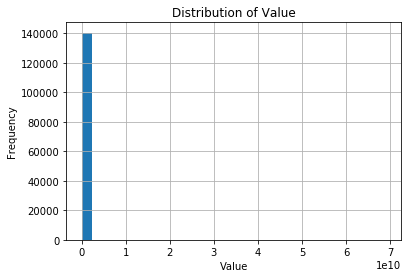


--- Country ---
GB: United Kingdom    2817
ZA: South Africa      1509
PT: Portugal          1404
FM: Micronesia        1028
PA: Panama            1028
BS: The Bahamas       1028
PH: Philippines        969
CA: Canada             969
US: United States      921
HU: Hungary            921
Name: Country, dtype: int64

--- Currency ---
EUR: Euro                        16294
XOF: CFA franc                    7324
XCD: Eastern Caribbean dollar     6592
XAF: CFA franc                    4944
GBP: Pound (sterling)             2817
USD: US dollar                    1949
AUD: Australian dollar            1649
ZAR: South African Rand           1509
PAB: Balboa                       1028
BSD: Bahamian dollar              1028
Name: Currency, dtype: int64

--- Time ---


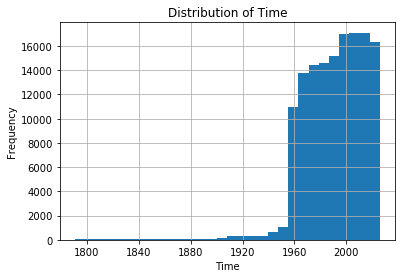

In [3]:

# --- 2. List all column names ---
print("🧾 Column names:")
print(df_bis.columns.tolist())

# --- 3. Basic info and summary stats ---
print("\n📊 Data info:")
print(df_bis.info())

print("\n📈 Numeric summary:")
print(df_bis.describe())

# --- 4. Look at value distributions / unique values for each column ---
for col in df_bis.columns:
    print(f"\n--- {col} ---")
    # For categorical columns:
    if df_bis[col].dtype == 'object':
        print(df_bis[col].value_counts().head(10))  # show top 10 values
    else:
        # For numeric columns: quick histogram
        df_bis[col].hist(bins=30)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()



# Load Rial Nominal Prices From Itan Excel

In [4]:
df_rial = pd.read_excel('DollorPrice2.xlsx', sheet_name="Monthly")

# Function to convert Jalali year/month to Gregorian datetime (first day of month)
def jalali_to_gregorian(year, month):
    return jdatetime.date(year, month, 1).togregorian()

# Apply to create a new datetime column
df_rial['Time'] = df_rial.apply(lambda row: jalali_to_gregorian(row['Year'], row['Month']), axis=1)

df_rial = df_rial[['Time', 'Price_Avg_(Rials)', 'Price_Avg_Real_(1000T)']]
df_rial['Time'] = pd.to_datetime(df_rial['Time'])

df_rial['Time'] = df_rial['Time'].dt.to_period('M').dt.to_timestamp()
df_rial['Country'] = 'IR: Iran'


df_rial_nominal = df_rial.rename(columns={
    'Price_Avg_(Rials)': 'Value',
})

df_rial_nominal['Currency'] = 'IRR: Rial_Nominal'

df_rial_nominal = df_rial_nominal[['Time', 'Country', 'Currency', 'Value']]


df_rial_real = df_rial.rename(columns={
    'Price_Avg_Real_(1000T)' : 'Value',
})

df_rial_real['Currency'] = 'IRR: Rial_Real'

df_rial_real = df_rial_real[['Time', 'Country', 'Currency', 'Value']]


df_combined = pd.concat([df_bis, df_rial_nominal, df_rial_real], ignore_index=True)


# Load CPI Data to Adjust Exchange Rates
Source : https://data.imf.org/en/datasets/IMF.STA:CPI

In [5]:
df_cpi = pd.read_csv('imf_cpi.csv')

df_cpi = df_cpi[
    (df_cpi['INDEX_TYPE'] == 'Consumer price index (CPI)') &
    (df_cpi['COICOP_1999'] == 'All Items') &
    (df_cpi['TYPE_OF_TRANSFORMATION'] == "Index") & 
    (df_cpi['FREQUENCY'] == 'Monthly')
]

# Keep only relevant columns
cpi_cols = ['COUNTRY'] + [c for c in df_cpi.columns if re.match(r'(19|20)\d{2}-M\d{2}$', c)]

cpi_df_small = df_cpi[cpi_cols]

# Melt CPI to long format
cpi_long = cpi_df_small.melt(id_vars=['COUNTRY'], 
                             var_name='Time', 
                             value_name='CPI')

# Example of Time column: '2025-M05' -> convert to datetime
cpi_long['Time'] = pd.to_datetime(cpi_long['Time'].str.replace('M','-'), format='%Y--%m')

/tmp/ipykernel_210084/3380567230.py:1: DtypeWarning: Columns (14,15,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cpi = pd.read_csv('imf_cpi.csv')


# Match Country Names between bis & cpi

In [6]:
df_bis = df_combined

df_bis['country'] = df_bis['Country'].str.split(':').str[1].str.strip()
cpi_long['country'] = cpi_long['COUNTRY']

In [8]:
# check if names are subsets of each other 
set2 = df_bis['country'].unique()
set1 = cpi_long['COUNTRY'].unique()
subset_check = all(
    any(name2 in name1 for name1 in set1)
    for name2 in set2
)
print(subset_check)

not_found = [
    name2 for name2 in set2
    if not any(name2 in name1 for name1 in set1)
]
print(not_found)
print(len(set1), len(set2), len(not_found))

False
['Czechia', 'The Bahamas', 'Euro area', 'Papua New Guinea', 'St Vincent and the Grenadines', 'Turkmenistan', 'Macao SAR', 'Hong Kong SAR', 'Slovakia', 'Micronesia', 'Australia', 'Waemu', 'The Gambia', 'St Kitts and Nevis', 'Chinese Taipei', 'St Lucia', 'Anguilla', 'Eritrea', 'Laos', 'Netherlands Antilles', 'Cayman Islands', 'New Zealand', 'Vanuatu', 'Republic of Congo']
190 183 24


In [9]:
# Example inputs
# df1['country'] → longer names
# df2['country'] → shorter names (possibly substrings of df1 names)

def build_substring_mapping(df1, df2):
    mapping = {}
    for c2 in df2['country'].unique():
        matches = [c1 for c1 in df1['country'].unique() if c2 in c1]
        if len(matches) == 1:
            mapping[c2] = matches[0]
        elif len(matches) > 1:
            # choose the shortest match (or first alphabetically)
            mapping[c2] = sorted(matches, key=len)[0]
        else:
            mapping[c2] = None
    return mapping

mapping = build_substring_mapping(cpi_long, df_bis)

# Turn into DataFrame to inspect
mapping_df = pd.DataFrame(list(mapping.items()), columns=['df2_country', 'df1_country_match'])

matched = sum(v is not None for v in mapping.values())
print(f"Matched {matched} out of {len(mapping)} countries")

df_bis['country_mapped'] = df_bis['country'].map(mapping)


Matched 159 out of 183 countries


# Merge ex rates with cpi

In [10]:
usd_cpi = cpi_long.rename(columns={'CPI': 'CPI_usd'})
usd_cpi = usd_cpi[usd_cpi['COUNTRY'] == 'United States']


In [11]:
df_merged_1 = pd.merge(df_bis, cpi_long, left_on=['country_mapped','Time'], right_on=['country','Time'], how='left')

df_merged = df_merged_1.merge(usd_cpi[['Time','CPI_usd']], on='Time', how='left')

df_final_1 = df_merged[['Time', 'Currency', 'country_x',  'Value', 'CPI', 'CPI_usd']]

df_final = df_final_1.rename(columns={
    'country_x' : 'Country',
})


In [12]:
df_final.sample(10)

,Time,Currency,Country,Value,CPI,CPI_usd
97131,1989-10-01,EUR: Euro,France,0.964635,66.052430,57.600015
80669,2014-03-01,XOF: CFA franc,Burkina Faso,474.556607,80.764442,108.363696
56993,1908-07-01,GBP: Pound (sterling),United Kingdom,0.205364,NaN,NaN
25199,1988-09-01,PHP: Philippine peso,Philippines,21.248500,NaN,54.940141
36556,2003-08-01,TOP: Pa'anga,Tonga,2.158895,NaN,84.657346
115120,1977-02-01,SCR: Seychelles rupee,Seychelles,7.797100,NaN,27.103192
45463,2001-05-01,MNT: Tugrik,Mongolia,1092.830000,NaN,81.493014
9615,1996-11-01,BBD: Barbados dollar,Barbados,2.000000,NaN,72.733776
139732,2005-02-01,EUR: Euro,Germany,0.768493,81.232500,87.959258
14377,2007-09-01,BAM: Bosnian convertible mark,Bosnia and Herzegovina,1.409241,88.036448,95.613273


### Remove Duplicate (Currency, Country)s

In [13]:
df_final = df_final[
    (~df_final['Country'].isin(['Kiribati', 'Micronesia'])) &
    (~df_final['Currency'].isin(['EUR: Euro', 'XAF: CFA franc', 'XCD: Eastern Caribbean dollar', 'XOF: CFA franc'])) 
]

In [14]:
dupes = df_final[df_final.duplicated(subset=['Time', 'Currency'], keep=False)]
print(dupes[('Currency')].value_counts())


Series([], Name: Currency, dtype: int64)


In [15]:
df_final.columns

Index(['Time', 'Currency', 'Country', 'Value', 'CPI', 'CPI_usd'], dtype='object')

### Add Real Currency Values

In [16]:
df_final['RER'] = df_final['Value'] * (df_final['CPI_usd'] / df_final['CPI'])


# Plot Nominal Values

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets, HBox, VBox, interactive_output
from IPython.display import display

# --- ensure Time is datetime ---
df = df_final

# --- helper functions to filter options based on search text ---
def update_country_options(change):
    text = change['new'].lower()
    filtered = [c for c in df['Country'].unique() if text in c.lower()]
    countries_widget.options = sorted(filtered)

def update_currency_options(change):
    text = change['new'].lower()
    filtered = [c for c in df['Currency'].unique() if text in c.lower()]
    currencies_widget.options = sorted(filtered)

# --- widgets ---
country_search = widgets.Text(
    description='🔍 Country',
    placeholder='Type to search...',
    layout=widgets.Layout(width='45%')
)
countries_widget = widgets.SelectMultiple(
    options=sorted(df['Country'].unique()),
    description='Countries',
    layout=widgets.Layout(width='45%')
)
country_search.observe(update_country_options, names='value')

currency_search = widgets.Text(
    description='🔍 Currency',
    placeholder='Type to search...',
    layout=widgets.Layout(width='45%')
)
currencies_widget = widgets.SelectMultiple(
    options=sorted(df['Currency'].unique()),
    description='Currencies',
    layout=widgets.Layout(width='45%')
)
currency_search.observe(update_currency_options, names='value')

time_start_widget = widgets.Text(
    value=str(df['Time'].min().date()),
    description='Start',
    placeholder='YYYY-MM-DD',
    layout=widgets.Layout(width='45%')
)
time_end_widget = widgets.Text(
    value=str(df['Time'].max().date()),
    description='End',
    placeholder='YYYY-MM-DD',
    layout=widgets.Layout(width='45%')
)

value_type_widget = widgets.Dropdown(
    options=['Value', 'CPI', 'CPI_usd', 'RER'],
    value='Value',
    description='Metric',
)

# --- plotting function ---
def plot_filtered(countries, currencies, time_start, time_end, metric):
    if not countries:
        countries = df['Country']
    
    if not currencies:
        currencies = df['Currency']
    
    
    try:
        tmin = pd.to_datetime(time_start)
        tmax = pd.to_datetime(time_end)
    except:
        print("❌ Invalid date format — use YYYY-MM-DD")
        return
    
    subset = df[
        (df['Country'].isin(countries)) &
        (df['Currency'].isin(currencies)) &
        (df['Time'].between(tmin, tmax))
    ]
    
    if subset.empty:
        print("⚠️ No data for this selection.")
        return

    # Pivot so countries are columns, currency ignored in pivot because multiple currencies
    pivot_df = subset.pivot_table(index='Time', columns='Country', values=metric, aggfunc='mean')
    
    pivot_df.plot(figsize=(25,7), title=f"{metric} for selected countries & currencies")
    plt.xlabel("Time")
    plt.ylabel(metric)
    plt.grid(True)
    plt.show()

# --- layout ---
ui = VBox([
    HBox([country_search, currency_search]),
    HBox([countries_widget, currencies_widget]),
    value_type_widget,
    HBox([time_start_widget, time_end_widget]),
])

out = interactive_output(
    plot_filtered,
    {
        'countries': countries_widget,
        'currencies': currencies_widget,
        'time_start': time_start_widget,
        'time_end': time_end_widget,
        'metric': value_type_widget
    }
)

display(ui, out)


Output()